In [ ]:
# import torch
# import torchvision
import numpy as np
import os
import cv2
import torchvision.transforms as tt


In [3]:
#Import training data
dir = "DS/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 10:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [4]:
import pickle

In [5]:
with open('subset.pickle', 'wb') as f:
    pickle.dump(train_data, f)

In [26]:
#Import validation data
val_dir = "DS/Validation/"
non_chars = ["#","$","&","@"]

val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [34]:
val_ds = CharRecog(val_data)

In [46]:
x, label = val_ds[10000]
print(x.shape)
print(label)

torch.Size([32, 32])
E


In [1]:
from sklearn.preprocessing import LabelBinarizer


FileNotFoundError: Could not find module 'C:\Users\Admin\anaconda3\lib\site-packages\scipy\.libs\libbanded5x.3OIBJ6VWWPY6GDLEMSTXSIPCHHWASXGT.gfortran-win_amd64.dll' (or one of its dependencies). Try using the full path with constructor syntax.

In [51]:
x = np.resize(x, (1,32,32))
np.max((x[0]))

1.0

In [2]:
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

In [32]:
#Create custom dataset class
class CharRecog(Dataset):

    def __init__(self, data_preload, transform=None):
        self.transform = transform
        self.data_X = []
        self.data_Y = []
        for features,label in data_preload:
            self.data_X.append(features)
            self.data_Y.append(label)
        self.data_X = np.array(self.data_X)/255.0
        self.data_Y = np.array(self.data_Y)
        
    def __len__(self):
        return len(self.data_X)

    def __getitem__(self, idx):
        #Data is expected to return one sample at a time
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Extract the image
        img = self.data_X[idx]
        img = torch.from_numpy(img)
        #Extract the label
        label = self.data_Y[idx]
        sample = (img, label)
        
        return sample

In [46]:
#Create dataset instances
train_ds = CharRecog(data_preload = train_data)
val_ds = CharRecog(data_preload = val_data)

In [47]:
#Adjust
batch_size=128

#Create dataloaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

In [4]:
#Tranfering to GPU if available
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [49]:
#See if GPU is available
device = get_default_device()

#Wrap the dataloaders to be used in GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

#Store in dict
dataloaders_dict = {'train': train_dl, 'val': val_dl}

In [ ]:
for img, lab in train_dl:
    img.shape, lab.shape
    break

In [43]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        
        out = self(images)                  # Generate predictions
        
        _, preds = torch.max(out, dim=1)
        corrects = torch.tensor(torch.sum(preds == labels)).item() #corrects
        loss = F.cross_entropy(out, labels) # Calculate loss
        
        return loss, corrects
    

In [10]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # output 32 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 16 x 16
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding =0), #64 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 7 x 7

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), #128 x 5 x 5
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 2 x 2
            
            nn.Dropout2d(0.25),
            nn.Flatten(), # output: 128*2*2 = 512
            
            nn.Linear(512, 128),
            nn.ReLU(),
            
            nn.Dropout(0.2),
            
            nn.Linear(128, 35),
            nn.Softmax())
            
    def forward(self, xb):
        return self.network(xb)

In [13]:
import time
import copy



In [45]:
?nn.Conv2d

In [21]:
def train_model(model, dataloaders, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # Get model outputs and calculate loss
                    loss, corrects = model.training_step(batch)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += corrects

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [8]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np

In [28]:
with open('logreg0.0001.pickle', 'rb') as handle:
    acc_history = pickle.load(handle)
    handle.close()

In [1]:
# print(acc_history)

In [29]:
val_acc = acc_history[0]
train_acc = acc_history[1]

In [6]:
batches = range(40)

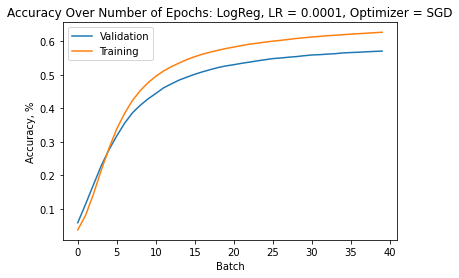

Best validation accuracy: 0.5703202051416925


In [31]:
plt.plot(batches, val_acc, label = 'Validation')
plt.plot(batches, train_acc, label = 'Training')
plt.title("Accuracy Over Number of Epochs: LogReg, LR = 0.0001, Optimizer = SGD")
plt.xlabel('Batch')
plt.ylabel('Accuracy, %')
plt.legend()
plt.show()

print('Best validation accuracy: ' + str(np.max(val_acc)))
